purpose: translate Rat GWAS into human orthologs (and maybe human to rat once a co-expression network made). After ortholog mapping, define seed gene sets. For ortho mapping- using bestmatch.

# Set-up

In [1]:
import os
import pandas as pd
import statsmodels.stats.multitest
from scipy import stats
import matplotlib.pyplot as plt
import re

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

# define ortholog dictionary

In [3]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
#downloaded from https://www.alliancegenome.org/downloads#orthology on 11 June 2024
#filter for rat-human
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']

In [4]:
ortho_best=ortho[ortho['IsBestScore']=='Yes']
ortho_best

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


In [5]:
ortho_best_both=ortho_best[ortho_best['IsBestRevScore']=='Yes']

lose 1753 genes if filter for best reverse

In [6]:
ortho[ortho['AlgorithmsMatch']>2]

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


In [7]:
len(set(ortho_best['Gene1Symbol']))-len(set(ortho_best['Gene2Symbol']))

1002

In [8]:
len(set(ortho_best_both['Gene1Symbol']))-len(set(ortho_best_both['Gene2Symbol']))

27

lose 1006 if filter for >2 databases rather than best ortholog

# Read in rat genes (MAGMA)

In [13]:
test='final_cf'

In [14]:
if ((test=='meta')|(test=='mega')):
    rat_magma=pd.read_csv('magma/loco_meta_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif test=='gsem':
    rat_magma=pd.read_csv('magma/loco_gsem_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif ((test=='final_cf')):
    rat_magma=pd.read_csv('magma/loco_final_cf_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif ((test=='final_mega')):
    rat_magma=pd.read_csv('magma/loco_final_mega_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif(test=='final_cf_25'):
    rat_magma=pd.read_csv('magma/loco_final_cf_7k_win25.genes.out',delim_whitespace=True,index_col=None,skiprows=1),
elif(test=='bmi_rn6'):
    rat_magma=pd.read_csv('magma/bmi_rn6_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif(test=='body_length_rn6'):
    rat_magma=pd.read_csv('magma/body_length_rn6_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)

In [15]:
rat_magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,Vom2r1,1,765164,795885,1,1,7679,1.18250,0.118500
1,Vom2r5,1,1151906,1180559,2,1,7679,1.66460,0.047999
2,Vom2r6,1,1204035,1232755,2,1,7679,1.77350,0.038072
3,LOC120098769,1,1954049,1978983,5,1,7679,-0.67169,0.749110
4,Raet1l,1,1969433,1994410,1,1,7679,0.19892,0.421160
...,...,...,...,...,...,...,...,...,...
18966,Ascc3,20,53500137,53805446,347,1,7679,0.82694,0.204130
18967,Sim1,20,53817601,53917219,152,1,7679,0.88070,0.189240
18968,LOC103694460,20,54404724,54428200,56,1,7679,0.85508,0.196250
18969,Cd99,20,54408239,54432882,53,1,7679,0.86448,0.193660


# test cutoffs

## bonferroni

In [16]:
0.05/len(rat_magma)

2.635601707869907e-06

In [18]:
len(rat_magma[rat_magma['P']<(0.05/len(rat_magma))])

10

## FDR

In [19]:
#compare before and after ortholog mapping
rat_magma['FDR_corr']=statsmodels.stats.multitest.fdrcorrection(rat_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

(array([ 893., 1027., 1141., 1655., 2005., 1897., 1670., 2064., 2348.,
        2924.]),
 array([1.03622070e-06, 9.99929326e-02, 1.99984829e-01, 2.99976725e-01,
        3.99968622e-01, 4.99960518e-01, 5.99952414e-01, 6.99944311e-01,
        7.99936207e-01, 8.99928104e-01, 9.99920000e-01]),
 <BarContainer object of 10 artists>)

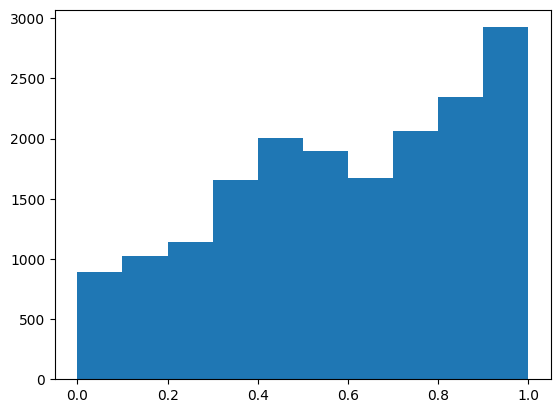

In [19]:
plt.hist(rat_magma['FDR_corr'])

In [20]:
len(rat_magma[rat_magma['FDR_corr']<0.05])

383

# merge in human orthologs

In [19]:
magma_out=rat_magma.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='GENE',right_on='Gene1Symbol',how='left').dropna().reset_index().drop(['index','Gene1Symbol'],axis=1)
magma_out.columns=['GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N', 'ZSTAT', 'P',
       'Q', 'HM_ORTHO']

In [20]:
if test=='meta':
    magma_out.to_csv('magma/seed_genes/loco_win10_annot.tsv',sep='\t', index=False)
elif test=='gsem':
    magma_out.to_csv('magma/seed_genes/loco_gsem_annot.tsv',sep='\t', index=False)
elif ((test=='final_cf')):
    magma_out.to_csv('magma/seed_genes/loco_final_cf_win10_annot.tsv',sep='\t',index=False)
elif ((test=='final_mega')):
    magma_out.to_csv('magma/seed_genes/loco_final_mega_win10_annot.tsv',sep='\t',index=False)
elif(test=='final_cf_25'):
    magma_out.to_csv('magma/seed_genes/loco_final_cf_win25_annot.tsv',sep='\t',index=False)
elif ((test=='bmi_rn6')):
    magma_out.to_csv('magma/seed_genes/bmi_rn6_annot.tsv',sep='\t',index=False)
elif ((test=='body_length_rn6')):
    magma_out.to_csv('magma/seed_genes/body_length_rn6_annot.tsv',sep='\t',index=False)

# externalizing (MAGMA)

In [3]:
set=['munged','orig']
file=set[1]

In [4]:
ext_magma=pd.read_csv('magma/ext_'+file+'.genes.out',delim_whitespace=True,index_col=None,skiprows=0)

In [8]:
gene_loc=pd.read_csv('/tscc/projects/ps-palmer/brittany/magma_v1/NCBI38/NCBI38.gene.loc',sep='\t',header=None)
gene_loc.columns=['ID','CHR','START','STOP','STAND','GENE_NAME']

In [6]:
ext_magma=gene_loc[['ID','GENE_NAME']].merge(ext_magma, left_on='ID',right_on='GENE',how='right').reset_index().drop(['index','GENE'],axis=1)
ext_magma.columns=['ID', 'GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N','ZSTAT', 'P']

In [9]:
ext_magma['Q']=statsmodels.stats.multitest.fdrcorrection(ext_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [10]:
ext_magma.to_csv('magma/seed_genes/ext_'+file+'_annot.tsv',sep='\t',index=False)

# externalizing (FUSION)

In [5]:
ext_fus=pd.read_csv('ext_FUSION/FUSION_concat/ext2019_GTEx.Brain_Nucleus_accumbens_basal_ganglia.dat',delim_whitespace=True)

In [8]:
ext_fus

,index,PANEL,FILE,ID,CHR,P0,P1,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,...,EQTL.R2,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P
0,2,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,DFFB,1,3773845,3801993,0.472,rs2821066,-3.99,...,0.286280,-5.29,1.6274,447,1,top1,0.290,2.400000e-08,-1.6274,0.104000
1,3,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,NPHP4,1,5922871,6046387,0.314,rs9662106,-3.53,...,0.106270,-4.21,-0.2524,534,6,lasso,0.130,3.100000e-04,0.1682,0.866000
2,4,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,NPPA-AS1,1,11901074,11908136,0.323,rs873458,4.34,...,0.005530,3.88,-1.4703,451,43,enet,0.050,1.800000e-02,-0.7213,0.471000
3,5,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,EMC1,1,19542158,19571524,0.396,rs16862800,3.15,...,0.305490,-5.38,0.9122,516,1,top1,0.310,6.700000e-09,-0.9122,0.362000
4,6,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,MRTO4,1,19581276,19586622,0.239,rs16862800,3.15,...,0.127920,-4.22,0.6546,492,1,top1,0.130,2.700000e-04,-0.6546,0.513000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,900,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,TTLL12,22,43562628,43583139,0.290,rs9612051,-3.63,...,-0.010790,-3.33,-2.7651,549,7,lasso,0.022,8.300000e-02,0.3132,0.754126
865,901,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,FAM118A,22,45704849,45737836,0.601,rs1894521,4.28,...,0.549325,7.22,0.5850,598,1,top1,0.550,1.800000e-17,0.5850,0.558520
866,902,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,CTA-29F11.1,22,47157791,47158460,0.473,rs8141788,-2.90,...,0.403552,-6.33,0.0601,539,1,top1,0.400,6.200000e-12,-0.0601,0.952102
867,903,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,RP3-402G11.26,22,50637519,50638976,0.482,rs11101951,3.30,...,0.246659,6.12,-2.3184,378,4,lasso,0.310,5.700000e-09,-2.5646,0.010330


In [7]:
ext_fus=ext_fus.dropna(subset=['ID','TWAS.P'],axis=0).reset_index()

In [9]:
ext_fus=ext_fus.drop('index',axis=1)

In [10]:
ext_fus['Q']=statsmodels.stats.multitest.fdrcorrection(ext_fus['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [16]:
ext_fus

,PANEL,FILE,ID,CHR,P0,P1,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,...,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,Q
0,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,DFFB,1,3773845,3801993,0.472,rs2821066,-3.99,rs12756705,...,-5.29,1.6274,447,1,top1,0.290,2.400000e-08,-1.6274,0.104000,0.291535
1,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,NPHP4,1,5922871,6046387,0.314,rs9662106,-3.53,rs806111,...,-4.21,-0.2524,534,6,lasso,0.130,3.100000e-04,0.1682,0.866000,0.926367
2,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,NPPA-AS1,1,11901074,11908136,0.323,rs873458,4.34,rs17037915,...,3.88,-1.4703,451,43,enet,0.050,1.800000e-02,-0.7213,0.471000,0.697273
3,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,EMC1,1,19542158,19571524,0.396,rs16862800,3.15,rs3748759,...,-5.38,0.9122,516,1,top1,0.310,6.700000e-09,-0.9122,0.362000,0.615613
4,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,MRTO4,1,19581276,19586622,0.239,rs16862800,3.15,rs10917277,...,-4.22,0.6546,492,1,top1,0.130,2.700000e-04,-0.6546,0.513000,0.729619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,TTLL12,22,43562628,43583139,0.290,rs9612051,-3.63,rs742134,...,-3.33,-2.7651,549,7,lasso,0.022,8.300000e-02,0.3132,0.754126,0.873628
865,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,FAM118A,22,45704849,45737836,0.601,rs1894521,4.28,rs104664,...,7.22,0.5850,598,1,top1,0.550,1.800000e-17,0.5850,0.558520,0.767965
866,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,CTA-29F11.1,22,47157791,47158460,0.473,rs8141788,-2.90,rs5769136,...,-6.33,0.0601,539,1,top1,0.400,6.200000e-12,-0.0601,0.952102,0.973229
867,NaN,./WEIGHTS//GTEx.Brain_Nucleus_accumbens_basal_...,RP3-402G11.26,22,50637519,50638976,0.482,rs11101951,3.30,rs2294385,...,6.12,-2.3184,378,4,lasso,0.310,5.700000e-09,-2.5646,0.010330,0.062339


In [53]:
ext_fus.to_csv('ext_FUSION/ext_fusion_NACC_seed.tsv',sep='\t',index=False)

# externalizing 2 factor (magmav1.08)

from supplemental tables in The Genetic and Neural Substrates of Externalizing Behavior. previous magma version but i need access from the university that published it to get sumstats so we're going to use this . pvalue cutoff from paper for bonferroni

In [6]:
ext_db=pd.read_csv('ext_2factor/MAGMA_v108_DB_bonf.tsv',sep='\t')
ext_rtb=pd.read_csv('ext_2factor/MAGMA_v108_RTB_bonf.tsv',sep='\t')

In [9]:
ext_db['Q']=statsmodels.stats.multitest.fdrcorrection(ext_db['P'],alpha=0.05,method='indep',is_sorted=False)[1]
ext_rtb['Q']=statsmodels.stats.multitest.fdrcorrection(ext_rtb['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [12]:
ext_db.to_csv('ext_2factor/MAGMA_v108_DB_bonf.tsv',sep='\t',index=None)
ext_rtb.to_csv('ext_2factor/MAGMA_v108_RTB_bonf.tsv',sep='\t',index=None)

# locomotor mega (FUSION)

In [6]:
def extract_IDs(annot, type=None):
    if (type=='gene'):
        #print('returning ENSRNOG')
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOG')]
        if len(ls)>0:
            return(ls[0])
    elif (type=='transcript'):
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOT')]
        if len(ls)>0:
            return(ls[0])
    else:
        return [x for x in re.split('[:.]', annot) if x.startswith('ENSR')]

In [12]:
loco_dir='loco_twas_dan/'

In [13]:
fus_rn_map=pd.read_csv(loco_dir+'rn7.gene.txt',sep='\t')

/tmp/ipykernel_1474359/1034971248.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  fus_rn_map=pd.read_csv(loco_dir+'rn7.gene.txt',sep='\t')


In [16]:
#downloaded from ensembl BioMart on 9 July 2024 for mRatBN7.2
gene_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.gene_map.gtf.gz',compression='gzip',sep='\t')
transcript_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.transcript_map.gtf.gz',compression='gzip',sep='\t')

In [17]:
#locomotor activity TWAS calculated by FUSION by Dan Munroe
tbl=pd.read_csv('loco_twas_dan/regressedlr_combined_locomotor.dat',sep='\t')
tbl['TISSUE']=[s.split('.')[1] for s in tbl.PANEL]
tbl['TYPE_MOD']=[s.split('.')[2] for s in tbl.PANEL]

In [18]:
tbl['ID_ls']=tbl['ID'].apply(extract_IDs)
tbl['gene_id']=tbl['ID'].apply(extract_IDs,type='gene')
tbl['tran_id']=tbl['ID'].apply(extract_IDs,type='transcript')

NameError: name 'extract_IDs' is not defined

In [12]:
#add in gene name
t=tbl.merge(gene_tbl[['Gene stable ID','Gene name']], left_on='gene_id',right_on='Gene stable ID',how='left').drop('Gene stable ID', axis=1)
t=t.merge(transcript_tbl[['Transcript stable ID','Transcript name']], left_on='tran_id',right_on='Transcript stable ID',how='left').drop('Transcript stable ID', axis=1)
#t_exp=t[t.TYPE_MOD=='expression']

In [13]:
t=t[(t['TYPE_MOD']=='expression')&(t['TISSUE']=='NAcc2')]

In [14]:
0.05/len(t)

9.338812103100487e-06

In [93]:
t=t.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='Gene name',right_on='Gene1Symbol',how='left')

In [97]:
t=t.dropna(subset=['Gene2Symbol','Gene1Symbol','TWAS.P'],axis=0).drop(['Gene1Symbol'],axis=1)

In [107]:
t['Q']=statsmodels.stats.multitest.fdrcorrection(t['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

/tmp/ipykernel_3504319/663195165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['Q']=statsmodels.stats.multitest.fdrcorrection(t['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]


In [109]:
t=t.rename(columns = {'Gene2Symbol':'human_ortholog'})

In [110]:
t.to_csv(loco_dir+'/loco_fusion_NACC_seed.tsv',sep='\t',index=False)

# loco_final_cf fusion

see TWAS_FUSION_predixcan notebook.